# bging

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import darts
from darts import TimeSeries
from darts.models import NaiveSeasonal, NaiveMean, NaiveDrift
from darts.models import StatsForecastAutoARIMA, StatsForecastAutoETS, StatsForecastAutoCES, RNNModel, ExponentialSmoothing, BlockRNNModel
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tqdm import tqdm_notebook as tqdm
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape, mase, mse, rmse, ase, ape, r2_score, smape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Flatten
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import random
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import tensorflow as tf
from tensorflow.keras import backend as K
import os

from hyperopt import base
os.environ['PYTHONHASHSEED'] = '0'
os.environ['HYPEROPT_FMIN_SEED'] = "1"
random.seed(88)
np.random.seed(88)
tf.random.set_seed(88)
base.have_been_bugged = False
rstate = np.random.default_rng(88)

/Users/jacobzhao/anaconda3/envs/prophet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
2024-06-22 19:03:31.688369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df_total = pd.read_csv('time_series_thesis_question_1.csv', index_col=0)
df_total.index = pd.to_datetime(df_total.index)
df_total = df_total.asfreq('QS')

In [4]:
df = TimeSeries.from_dataframe(df_total)

In [5]:
NN_train_tf, _ = df.split_before(pd.Timestamp('20220401'))

In [6]:
train_1, val_1 = df.split_before(pd.Timestamp('20230101'))
train_2, val_2 = df.split_before(pd.Timestamp('20230401'))
train_3, val_3 = df.split_before(pd.Timestamp('20230701'))

In [7]:
import darts
def NN_metricker(y_pred):
  y_pred_df = pd.DataFrame(y_pred.reshape((-1, 3)).transpose())
  y_pred_df.columns = df_total.columns
  y_pred_df.index = df_total.index[-3:]
  y_pred_df.index = pd.to_datetime(y_pred_df.index)
  y_pred_tf = TimeSeries.from_dataframe(y_pred_df)
  SMAPE = darts.metrics.smape(val_1, y_pred_tf)
  MASE = darts.metrics.mase(val_1, y_pred_tf, train_1)
  MAE = darts.metrics.mae(val_1, y_pred_tf)
  print(
      "Symmetric Mean absolute percentage error: {:.2f}%.".format(
          SMAPE),
          "MASE: {:.2f}".format(MASE),
          "MAE: {:.2f}".format(MAE)
      )
  return y_pred_df, SMAPE, MASE, MAE



In [8]:
def Xy(sliding_windows):
    X = [[list(window[:-1]) for window in windows] for windows in sliding_windows]
    y = [[window[-1] for window in windows] for windows in sliding_windows]
    return np.array(X), np.array(y)

In [9]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

def spliter(df_total,
            k = 4,
            test_size = 3,
            val_size = 3):
    test = []
    val = []
    train = []
    NN_sets = {}
    window_size = k+1


    for col in df_total.columns:
        windows = [np.array(window) for window in df_total[col].rolling(window_size) if len(window) == window_size]
        test.append(windows[-(test_size):])
        val.append(windows[-(test_size+val_size):-(test_size)])
        train.append(windows[:-(test_size+val_size)])
    NN_sets['X_train'], NN_sets['y_train'] = Xy(train)
    NN_sets['X_val'], NN_sets['y_val'] = Xy(val)
    NN_sets['X_test'], NN_sets['y_test'] = Xy(test)
    return NN_sets

#NN_sets = spliter(df_total, k=4)

In [10]:
def add_noise_to_latter_part(sequence, noise_start_ratio=0.75, noise_scale=0.5):
    seq_length = len(sequence)
    noise_start = int(seq_length * noise_start_ratio)
    
    noisy_sequence = sequence.copy()
    
    # Generate noise for the latter part
    noise = np.random.normal(0, noise_scale, seq_length - noise_start)
    
    # Add noise to the latter part of the sequence
    noisy_sequence[noise_start:] += noise
    
    return noisy_sequence

# Shuffle CNN

In [97]:
def create_2cnn_model(window, n_layers, n_nodes, optimizer_name, lr, kernel_size, df=df_total):
    NN_sets = spliter(df, k=window)

    model = Sequential()
    model.add(Conv1D(filters=n_nodes, kernel_size= kernel_size, activation='relu', input_shape=(window, 1)))
    model.add(Conv1D(filters=n_nodes/2, kernel_size=kernel_size, activation='relu', input_shape=(window, 1)))
    model.add(Flatten())

    for _ in range(n_layers):
        model.add(Dense(n_nodes/2, activation='relu'))

    model.add(Dense(1))

    optimizer_class = {'adam': Adam, 'rmsprop': RMSprop, 'sgd': SGD, 'nadam': Nadam}[optimizer_name]
    optimizer = optimizer_class(lr)

    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())

    return model, NN_sets

In [115]:
best = {'kernel_size': 0, 'lr': 4, 'n_layers': 1, 'n_nodes': 1, 'optimizer': 2, 'window': 1}
# Hyperparameters to tune
window_values = [16, 20, 24, 28]
hidden_layers_values = [1, 2, 3]
hidden_nodes_values = [8, 16, 32, 64]
optimizer_values = ['adam', 'rmsprop', 'nadam']
kernel_size_values = [3, 5, 7, 9, 12]
lr_values = list(np.arange(1e-4, 11e-4, 1e-4))

best_window = window_values[best['window']]
best_n_layers = hidden_layers_values[best['n_layers']]
best_n_nodes = hidden_nodes_values[best['n_nodes']]
best_optimizer_name = optimizer_values[best['optimizer']]
best_lr = lr_values[best['lr']]
best_kernel_size = kernel_size_values[best['kernel_size']]

print(f"Best Window: {best_window}")
print(f"Best Number of Layers: {best_n_layers}")
print(f"Best Number of Nodes: {best_n_nodes}")
print(f"Best Optimizer Name: {best_optimizer_name}")
print(f"Best Learning Rate: {best_lr}")
print(f"Best Kernel Size: {best_kernel_size}")
y_pred_cnn_shuffled_df, SMAPE, MASE, MAE = shuffle_f_and_fit_and_predict(best_window, best_n_layers, best_n_nodes, best_optimizer_name, best_lr, best_kernel_size)  

Best Window: 20
Best Number of Layers: 2
Best Number of Nodes: 16
Best Optimizer Name: nadam
Best Learning Rate: 0.0005
Best Kernel Size: 3
73/73 [==============================] - 0s 898us/step
Symmetric Mean absolute percentage error: 15.79%. MASE: 1.29 MAE: 1.23


In [99]:

def shuffle_and_fit_and_predict(window, n_layers, n_nodes, optimizer_name, lr, kernel_size, m):
    best_model, NN_sets = create_2cnn_model(window, n_layers, n_nodes, optimizer_name, lr, kernel_size)
    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    ## SHUFFLE
    shuffled_X_train = np.copy(NN_sets['X_train'].reshape((-1, window)))
    shuffled_X_val = np.copy(NN_sets['X_val'].reshape((-1, window)))


    for idx in np.ndindex(shuffled_X_train.shape[:-1]):  # 获取除了最内层以外的索引
        np.random.shuffle(shuffled_X_train[idx][m:])  # 打乱除了最后一个元素以外的元素

    for idx in np.ndindex(shuffled_X_val.shape[:-1]):  # 获取除了最内层以外的索引
        np.random.shuffle(shuffled_X_val[idx][m:])  # 打乱除了最后一个元素以外的元素


    history = best_model.fit(shuffled_X_train,
                             NN_sets['y_train'].reshape((-1, 1)),
                             epochs=30,
                             batch_size=20,
                             validation_data=(shuffled_X_val,
                                              NN_sets['y_val'].reshape((-1, 1))),
                             callbacks=[early_stop], verbose=0)


    y_pred_cnn_shuffled = best_model.predict(NN_sets['X_test'].reshape((-1, best_window, 1)))
    y_pred_cnn_shuffled_df, SMAPE, MASE, MAE = NN_metricker(y_pred_cnn_shuffled)
    return y_pred_cnn_shuffled_df, SMAPE, MASE, MAE


In [73]:

def shuffle_f_and_fit_and_predict(window, n_layers, n_nodes, optimizer_name, lr, kernel_size):
    best_model, NN_sets = create_2cnn_model(window, n_layers, n_nodes, optimizer_name, lr, kernel_size)
    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    ## SHUFFLE
    shuffled_X_train = np.copy(NN_sets['X_train'].reshape((-1, window)))
    shuffled_X_val = np.copy(NN_sets['X_val'].reshape((-1, window)))


    for idx in np.ndindex(shuffled_X_train.shape[:-1]):  # 获取除了最内层以外的索引
        np.random.shuffle(shuffled_X_train[idx][:-1])  # 打乱除了最后一个元素以外的元素

    for idx in np.ndindex(shuffled_X_val.shape[:-1]):  # 获取除了最内层以外的索引
        np.random.shuffle(shuffled_X_val[idx][:-1])  # 打乱除了最后一个元素以外的元素


    history = best_model.fit(shuffled_X_train,
                             NN_sets['y_train'].reshape((-1, 1)),
                             epochs=30,
                             batch_size=20,
                             validation_data=(shuffled_X_val,
                                              NN_sets['y_val'].reshape((-1, 1))),
                             callbacks=[early_stop], verbose=0)


    y_pred_cnn_shuffled = best_model.predict(NN_sets['X_test'].reshape((-1, best_window, 1)))
    y_pred_cnn_shuffled_df, SMAPE, MASE, MAE = NN_metricker(y_pred_cnn_shuffled)
    return y_pred_cnn_shuffled_df, SMAPE, MASE, MAE


In [116]:
my_list = [-i for i in range(1, 21)]
smape_list_cnn_shuffled = []
mase_list_cnn_shuffled = []
mae_list_cnn_shuffled = []

for m in my_list:
  print(f"m: {m}")
  y_pred_cnn_shuffled_df, SMAPE, MASE, MAE = shuffle_and_fit_and_predict(best_window, best_n_layers, best_n_nodes, best_optimizer_name, best_lr, best_kernel_size, m)  
  smape_list_cnn_shuffled.append(SMAPE)
  mase_list_cnn_shuffled.append(MASE)
  mae_list_cnn_shuffled.append(MAE)


# Create DataFrame directly (no intermediate dictionary)
cnn_detailed_df = pd.DataFrame(
    {
        'SMAPE': smape_list_cnn_shuffled,
        'MASE': mase_list_cnn_shuffled,
        'MAE': mae_list_cnn_shuffled
    },
    index=my_list  # Set 'm' values as the index
)

m: -1
73/73 [==============================] - 0s 1ms/step
Symmetric Mean absolute percentage error: 15.28%. MASE: 1.18 MAE: 1.18
m: -2
73/73 [==============================] - 0s 989us/step
Symmetric Mean absolute percentage error: 15.87%. MASE: 1.22 MAE: 1.23
m: -3
73/73 [==============================] - 0s 972us/step
Symmetric Mean absolute percentage error: 17.53%. MASE: 1.33 MAE: 1.34
m: -4
73/73 [==============================] - 0s 949us/step
Symmetric Mean absolute percentage error: 18.42%. MASE: 1.41 MAE: 1.41
m: -5
73/73 [==============================] - 0s 1ms/step
Symmetric Mean absolute percentage error: 19.29%. MASE: 1.46 MAE: 1.47
m: -6
73/73 [==============================] - 0s 972us/step
Symmetric Mean absolute percentage error: 19.70%. MASE: 1.53 MAE: 1.50
m: -7
73/73 [==============================] - 0s 1ms/step
Symmetric Mean absolute percentage error: 19.71%. MASE: 1.49 MAE: 1.49
m: -8
73/73 [==============================] - 0s 994us/step
Symmetric Mean absolu

In [ ]:
import pickle
with open('cnn_detailed_df', 'wb') as f:
    pickle.dump(cnn_detailed_df, f)

# Shuffle LSTM

In [120]:

K.clear_session()
tf.keras.backend.clear_session()
from tensorflow.keras.losses import Huber
def create_lstm_model(window, lstm_units, n_lstm_layers, optimizer_name, lr, dp, df=df_total):
    NN_sets = spliter(df, k=window)
    lstm_model = Sequential()
    if n_lstm_layers == 1:
        lstm_model.add(LSTM(lstm_units, return_sequences=False, input_shape=(window,1)))
    elif n_lstm_layers == 2:
        lstm_model.add(LSTM(lstm_units, return_sequences=True, input_shape=(window,1)))
        lstm_model.add(LSTM(lstm_units // 2, return_sequences=False))
    elif n_lstm_layers == 3:
        lstm_model.add(LSTM(lstm_units, return_sequences=True, input_shape=(window,1)))
        lstm_model.add(LSTM(lstm_units // 2, return_sequences=True))
        lstm_model.add(LSTM(lstm_units // 4, return_sequences=False))


    lstm_model.add(Dropout(dp))
    lstm_model.add(Dense(units=1))

    optimizer_class = {'adam': Adam, 'rmsprop': RMSprop, 'sgd': SGD, 'nadam': Nadam}[optimizer_name]
    optimizer = optimizer_class(lr)

    lstm_model.compile(optimizer=optimizer, loss=Huber())


    return lstm_model, NN_sets


In [121]:
window_values = [16, 20, 24, 28]
lstm_units_values = [16, 32, 64, 128]
n_lstm_layers_values = [1, 2, 3]
optimizer_values = ['adam', 'rmsprop', 'nadam']
lr_values = list(np.arange(1e-4, 11e-4, 1e-4))
dropout_values = [0]
best = {'dropout_value': 0, 'lr': 4, 'lstm_units': 3, 'n_lstm_layers': 0, 'optimizer': 0, 'window': 1}
best_window = window_values[best['window']]
best_n_lstm_layers = n_lstm_layers_values[best['n_lstm_layers']]
best_lstm_units = lstm_units_values[best['lstm_units']]
best_optimizer_name =  optimizer_values[best['optimizer']]
best_lr = lr_values[best['lr']]
best_dropout_value = dropout_values[best['dropout_value']]
print(f"Best window size: {best_window}")
print(f"Best number of LSTM layers: {best_n_lstm_layers}")
print(f"Best number of LSTM units: {best_lstm_units}")
print(f"Best optimizer: {best_optimizer_name}")
print(f"Best learning rate: {best_lr}")
print(f"Best dropout rate: {best_dropout_value}")
y_pred_lstm_shuffled_df, SMAPE, MASE, MAE = shuffle_f_and_fit_and_predict_lstm(
        best_window, best_lstm_units, best_n_lstm_layers, 
        best_optimizer_name, best_lr, best_dropout_value
    )

Best window size: 20
Best number of LSTM layers: 1
Best number of LSTM units: 128
Best optimizer: adam
Best learning rate: 0.0005
Best dropout rate: 0
73/73 [==============================] - 2s 4ms/step
Symmetric Mean absolute percentage error: 14.44%. MASE: 1.13 MAE: 1.14


In [108]:

def shuffle_and_fit_and_predict_lstm(window, lstm_units, n_lstm_layers, optimizer_name, lr, dp, m):
    best_model, NN_sets = create_lstm_model(window, lstm_units, n_lstm_layers, optimizer_name, lr, dp)
    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    ## SHUFFLE
    shuffled_X_train = np.copy(NN_sets['X_train'].reshape((-1, window)))
    shuffled_X_val = np.copy(NN_sets['X_val'].reshape((-1, window)))


    for idx in np.ndindex(shuffled_X_train.shape[:-1]):  # 获取除了最内层以外的索引
        np.random.shuffle(shuffled_X_train[idx][m:])  # 打乱除了最后一个元素以外的元素

    for idx in np.ndindex(shuffled_X_val.shape[:-1]):  # 获取除了最内层以外的索引
        np.random.shuffle(shuffled_X_val[idx][m:])  # 打乱除了最后一个元素以外的元素



    history = best_model.fit(
        shuffled_X_train,
        NN_sets['y_train'].reshape((-1, 1)),
        epochs=30,
        batch_size=20,
        validation_data=(shuffled_X_val, NN_sets['y_val'].reshape((-1, 1))),
        callbacks=[early_stop], verbose=0
    )


    y_pred_lstm_shuffled = best_model.predict(NN_sets['X_test'].reshape((-1, best_window, 1)))
    y_pred_lstm_shuffled_df, SMAPE, MASE, MAE = NN_metricker(y_pred_lstm_shuffled)
    return y_pred_lstm_shuffled_df, SMAPE, MASE, MAE


In [76]:

        

def shuffle_f_and_fit_and_predict_lstm(window, lstm_units, n_lstm_layers, optimizer_name, lr, dp):
    best_model, NN_sets = create_lstm_model(window, lstm_units, n_lstm_layers, optimizer_name, lr, dp)
    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    ## SHUFFLE
    shuffled_X_train = np.copy(NN_sets['X_train'].reshape((-1, window)))
    shuffled_X_val = np.copy(NN_sets['X_val'].reshape((-1, window)))

    for idx in np.ndindex(shuffled_X_train.shape[:-1]):  # 获取除了最内层以外的索引
        np.random.shuffle(shuffled_X_train[idx][:-1])  # 打乱除了最后一个元素以外的元素

    for idx in np.ndindex(shuffled_X_val.shape[:-1]):  # 获取除了最内层以外的索引
        np.random.shuffle(shuffled_X_val[idx][:-1])  # 打乱除了最后一个元素以外的元素
        
        
    history = best_model.fit(
        shuffled_X_train,
        NN_sets['y_train'].reshape((-1, 1)),
        epochs=30,
        batch_size=20,
        validation_data=(shuffled_X_val, NN_sets['y_val'].reshape((-1, 1))),
        callbacks=[early_stop], verbose=0
    )


    y_pred_lstm_shuffled = best_model.predict(NN_sets['X_test'].reshape((-1, best_window, 1)))
    y_pred_lstm_shuffled_df, SMAPE, MASE, MAE = NN_metricker(y_pred_lstm_shuffled)
    return y_pred_lstm_shuffled_df, SMAPE, MASE, MAE


In [109]:
window_values = [16, 20, 24, 28]
lstm_units_values = [16, 32, 64, 128]
n_lstm_layers_values = [1, 2, 3]
optimizer_values = ['adam', 'rmsprop', 'nadam']
lr_values = list(np.arange(1e-4, 11e-4, 1e-4))
dropout_values = [0]
best = {'dropout_value': 0, 'lr': 4, 'lstm_units': 3, 'n_lstm_layers': 0, 'optimizer': 0, 'window': 1}
best_window = window_values[best['window']]
best_n_lstm_layers = n_lstm_layers_values[best['n_lstm_layers']]
best_lstm_units = lstm_units_values[best['lstm_units']]
best_optimizer_name =  optimizer_values[best['optimizer']]
best_lr = lr_values[best['lr']]
best_dropout_value = dropout_values[best['dropout_value']]
print(f"Best window size: {best_window}")
print(f"Best number of LSTM layers: {best_n_lstm_layers}")
print(f"Best number of LSTM units: {best_lstm_units}")
print(f"Best optimizer: {best_optimizer_name}")
print(f"Best learning rate: {best_lr}")
print(f"Best dropout rate: {best_dropout_value}")
# Lists to store results
smape_list_lstm_shuffled = []
mase_list_lstm_shuffled = []
mae_list_lstm_shuffled = []

  # Main Loop: Iterate over 'm' values
for m in my_list:
    print(f"m: {m}")
    y_pred_lstm_shuffled_df, SMAPE, MASE, MAE = shuffle_and_fit_and_predict_lstm(
        best_window, best_lstm_units, best_n_lstm_layers, 
        best_optimizer_name, best_lr, best_dropout_value, m
    )

    smape_list_lstm_shuffled.append(SMAPE)
    mase_list_lstm_shuffled.append(MASE)
    mae_list_lstm_shuffled.append(MAE)

# Create DataFrame directly (no intermediate dictionary)
lstm_detailed_df = pd.DataFrame(
    {
        'SMAPE': smape_list_lstm_shuffled,
        'MASE': mase_list_lstm_shuffled,
        'MAE': mae_list_lstm_shuffled
    },
    index=my_list  # Set 'm' values as the index
)

Best window size: 20
Best number of LSTM layers: 1
Best number of LSTM units: 128
Best optimizer: adam
Best learning rate: 0.0005
Best dropout rate: 0
m: -1
73/73 [==============================] - 1s 4ms/step
Symmetric Mean absolute percentage error: 14.30%. MASE: 1.11 MAE: 1.12
m: -2
73/73 [==============================] - 1s 4ms/step
Symmetric Mean absolute percentage error: 15.60%. MASE: 1.21 MAE: 1.21
m: -3
73/73 [==============================] - 1s 4ms/step
Symmetric Mean absolute percentage error: 16.94%. MASE: 1.30 MAE: 1.30
m: -4
73/73 [==============================] - 1s 4ms/step
Symmetric Mean absolute percentage error: 17.95%. MASE: 1.37 MAE: 1.37
m: -5
73/73 [==============================] - 1s 4ms/step
Symmetric Mean absolute percentage error: 18.39%. MASE: 1.41 MAE: 1.40
m: -6
73/73 [==============================] - 1s 4ms/step
Symmetric Mean absolute percentage error: 19.56%. MASE: 1.54 MAE: 1.54
m: -7
73/73 [==============================] - 1s 4ms/step
Symmetric 

In [52]:

with open('lstm_detailed_df', 'wb') as f:
    pickle.dump(lstm_detailed_df, f)


In [122]:
import pandas as pd
lstm_dfs = []
for _ in range(10):



  m_list = [-i for i in range(1, 21)]

  # Lists to store results
  smape_list_lstm_shuffled = []
  mase_list_lstm_shuffled = []
  mae_list_lstm_shuffled = []

  # Main Loop: Iterate over 'm' values
  for m in m_list:
      y_pred_lstm_shuffled_df, SMAPE, MASE, MAE = shuffle_and_fit_and_predict_lstm(
          best_window, best_lstm_units, best_n_lstm_layers,
          best_optimizer_name, best_lr, best_dropout_value, m
      )

      # Append results
      smape_list_lstm_shuffled.append(SMAPE)
      mase_list_lstm_shuffled.append(MASE)
      mae_list_lstm_shuffled.append(MAE)

  # Create DataFrame directly (no intermediate dictionary)
  df = pd.DataFrame(
      {
          'SMAPE': smape_list_lstm_shuffled,
          'MASE': mase_list_lstm_shuffled,
          'MAE': mae_list_lstm_shuffled
      },
      index=m_list  # Set 'm' values as the index
  )
  lstm_dfs.append(df)

median_df = pd.DataFrame(np.median(lstm_dfs, axis=0))


73/73 [==============================] - 1s 5ms/step
Symmetric Mean absolute percentage error: 19.92%. MASE: 1.55 MAE: 1.51
73/73 [==============================] - 1s 5ms/step
Symmetric Mean absolute percentage error: 20.44%. MASE: 1.60 MAE: 1.61
73/73 [==============================] - 1s 5ms/step
Symmetric Mean absolute percentage error: 20.22%. MASE: 1.59 MAE: 1.60
73/73 [==============================] - 1s 5ms/step
Symmetric Mean absolute percentage error: 20.84%. MASE: 1.63 MAE: 1.63
73/73 [==============================] - 1s 5ms/step
Symmetric Mean absolute percentage error: 20.69%. MASE: 1.58 MAE: 1.57
73/73 [==============================] - 2s 4ms/step
Symmetric Mean absolute percentage error: 20.62%. MASE: 1.61 MAE: 1.62
73/73 [==============================] - 2s 5ms/step
Symmetric Mean absolute percentage error: 20.33%. MASE: 1.63 MAE: 1.63
73/73 [==============================] - 2s 5ms/step
Symmetric Mean absolute percentage error: 21.26%. MASE: 1.70 MAE: 1.75
73/73 [=

In [123]:

with open('lstm_dfs_shuffled_m_1_20.pkl', 'wb') as f:
  pickle.dump(lstm_dfs, f)

# Shuffle CNNLSTM

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense
from tensorflow.keras.losses import Huber
def create_cnn_lstm_model(window, lstm_layers, n_filters, optimizer_name, lr, kernel_size):
    NN_sets = spliter(df_total, k=window) 

    model = Sequential()
    
    # CNN part
    model.add(Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu'))
    
    for _ in range(lstm_layers):
        model.add(LSTM(n_filters, return_sequences=True))
    
    # LSTM part
    model.add(LSTM(n_filters // 2, return_sequences=False))
    
    # Output layer
    model.add(Dense(1))
    
    optimizer_class = {'adam': Adam, 'rmsprop': RMSprop, 'sgd': SGD, 'nadam': Nadam}[optimizer_name]
    optimizer = optimizer_class(lr)
    model.compile(optimizer=optimizer, loss=Huber())
    
    return model, NN_sets

In [34]:

n_lstm_layers_values = [1, 2]
n_filters_values = [8, 16, 32, 64, 128]
optimizer_values = ['adam', 'rmsprop', 'nadam']
window_values = [16, 20, 24, 28]
kernel_size_values = [3, 5, 7, 9]
lr_values = list(np.arange(1e-4, 11e-4, 1e-4))
best = {'kernel_size': 0, 'lr': 8, 'n_filters': 1, 'n_lstm_layers': 0, 'optimizer': 2, 'window': 0}
best_window = window_values[best['window']]
best_n_lstm_layers = n_lstm_layers_values[best['n_lstm_layers']]
best_n_filters = n_filters_values[best['n_filters']]
best_optimizer_name = optimizer_values[best['optimizer']]
best_lr = lr_values[best['lr']]
best_kernel_size = kernel_size_values[best['kernel_size']]

print(f"Best window size: {best_window}")
print(f"Best number of LSTM layers: {best_n_lstm_layers}")
print(f"Best number of filters: {best_n_filters}")
print(f"Best optimizer: {best_optimizer_name}")
print(f"Best learning rate: {best_lr}")
print(f"Best kernel size: {best_kernel_size}")

Best window size: 16
Best number of LSTM layers: 1
Best number of filters: 16
Best optimizer: nadam
Best learning rate: 0.0009000000000000001
Best kernel size: 3


In [35]:

def shuffle_and_fit_and_predict_cnnlstm(window, lstm_layers, n_filters, optimizer_name, lr, kernel_size, m):
    best_model, NN_sets = create_cnn_lstm_model(window, lstm_layers, n_filters, optimizer_name, lr, kernel_size)
    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    ## SHUFFLE
    shuffled_X_train = np.copy(NN_sets['X_train'].reshape((-1, window, 1)))
    shuffled_X_val = np.copy(NN_sets['X_val'].reshape((-1, window, 1)))


    for idx in np.ndindex(shuffled_X_train.shape[:-1]):  # 获取除了最内层以外的索引
        np.random.shuffle(shuffled_X_train[idx][m:])  # 打乱除了最后一个元素以外的元素

    for idx in np.ndindex(shuffled_X_val.shape[:-1]):  # 获取除了最内层以外的索引
        np.random.shuffle(shuffled_X_val[idx][m:])  # 打乱除了最后一个元素以外的元素


    history = best_model.fit(shuffled_X_train,
                             NN_sets['y_train'].reshape((-1, 1)),
                             epochs=30,
                             batch_size=20,
                             validation_data=(shuffled_X_val,
                                              NN_sets['y_val'].reshape((-1, 1))),
                             callbacks=[early_stop], verbose=0)


    y_pred_cnnlstm_shuffled = best_model.predict(NN_sets['X_test'].reshape((-1, best_window, 1)))
    y_pred_cnnlstm_shuffled_df, SMAPE, MASE, MAE = NN_metricker(y_pred_cnnlstm_shuffled)
    return y_pred_cnnlstm_shuffled_df, SMAPE, MASE, MAE


In [36]:
my_list = [-i for i in range(1, 21)]
smape_list_cnnlstm_shuffled = []
mase_list_cnnlstm_shuffled = []
mae_list_cnnlstm_shuffled = []

for m in my_list:
  print(f"m: {m}")
  y_pred_cnnlstm_shuffled_df, SMAPE, MASE, MAE = shuffle_and_fit_and_predict(best_window, best_n_layers, best_n_nodes, best_optimizer_name, best_lr, best_kernel_size, m)  
  smape_list_cnnlstm_shuffled.append(SMAPE)
  mase_list_cnnlstm_shuffled.append(MASE)
  mae_list_cnnlstm_shuffled.append(MAE)


# Create DataFrame directly (no intermediate dictionary)
cnnlstm_detailed_df = pd.DataFrame(
    {
        'SMAPE': smape_list_cnnlstm_shuffled,
        'MASE': mase_list_cnnlstm_shuffled,
        'MAE': mae_list_cnnlstm_shuffled
    },
    index=my_list  # Set 'm' values as the index
)

m: -1
73/73 [==============================] - 0s 782us/step
Symmetric Mean absolute percentage error: 14.75%. MASE: 1.15 MAE: 1.17
m: -2
73/73 [==============================] - 0s 805us/step
Symmetric Mean absolute percentage error: 15.82%. MASE: 1.22 MAE: 1.22
m: -3
73/73 [==============================] - 0s 805us/step
Symmetric Mean absolute percentage error: 17.17%. MASE: 1.31 MAE: 1.31
m: -4
73/73 [==============================] - 0s 749us/step
Symmetric Mean absolute percentage error: 18.41%. MASE: 1.39 MAE: 1.41
m: -5
73/73 [==============================] - 0s 759us/step
Symmetric Mean absolute percentage error: 20.30%. MASE: 1.54 MAE: 1.56
m: -6
73/73 [==============================] - 0s 778us/step
Symmetric Mean absolute percentage error: 19.02%. MASE: 1.43 MAE: 1.44
m: -7
73/73 [==============================] - 0s 755us/step
Symmetric Mean absolute percentage error: 19.64%. MASE: 1.53 MAE: 1.53
m: -8
73/73 [==============================] - 0s 810us/step
Symmetric Mean 

# Visualisation

In [22]:
import pandas as pd

# Specify the file path
file_path = '/Users/jacobzhao/Desktop/March 1 2024/cnnlstm_detailed_df.pkl'

# Read the pickle file
cnnlstm_detailed_df_ = pd.read_pickle(file_path)

In [ ]:
metrics_shuffle_lv_df = pd.read_pickle('metrics_shuffle_lv_df.pkl')
metrics_shuffle_lv_df.index = [-i for i in range(1, 21)]

In [24]:
cnn_list = pd.read_pickle('cnn_dfs_shuffled_m_1_20.pkl')
lstm_list = pd.read_pickle('lstm_dfs_shuffled_m_1_20.pkl')
cnn_median = pd.DataFrame(np.median(cnn_list, axis=0))
lstm_median = pd.DataFrame(np.median(lstm_list, axis=0))

In [31]:
cnn_mean = pd.DataFrame(np.mean(cnn_list, axis=0))
lstm_mean = pd.DataFrame(np.mean(lstm_list, axis=0))

In [41]:
mean_metrics = pd.read_pickle('mean_metrics_df.pkl')
lstm_median.columns = ['SMAPE', 'MASE', 'MAE']
lstm_median.index = [(i-1)/20 for i in range(1, 21)]
cnn_median.columns = ['SMAPE', 'MASE', 'MAE']
cnn_median.index = [(i-1)/20 for i in range(1, 21)]
lstm_mean.columns = ['SMAPE', 'MASE', 'MAE']
lstm_mean.index = [(i-1)/20 for i in range(1, 21)]
cnn_mean.columns = ['SMAPE', 'MASE', 'MAE']
cnn_mean.index =[(i-1)/20 for i in range(1, 21)]
mean_metrics = pd.read_pickle('mean_metrics_df.pkl')
mean_metrics.index =[(i-1)/20 for i in range(1, 21)]

In [80]:
metrics_shuffle_lv_df = pd.read_pickle('metrics_shuffle_lv_df.pkl')
metrics_shuffle_lv_df.index = [(i-1)/20 for i in range(1, 21)]

In [78]:
metrics_shuffle_lv_df['']

,MAE,MASE,SMAPE
0.00,14.593907,1.095217,1.146673
0.05,17.360733,1.298002,1.308356
0.10,19.974995,1.509266,1.514723
0.15,21.196042,1.568306,1.566925
0.20,21.982045,1.633706,1.644211
0.25,22.119016,1.657978,1.675557
0.30,22.614005,1.716577,1.716251
0.35,23.547013,1.802309,1.816806
0.40,23.625993,1.811447,1.813225
0.45,24.442640,1.898693,1.907787


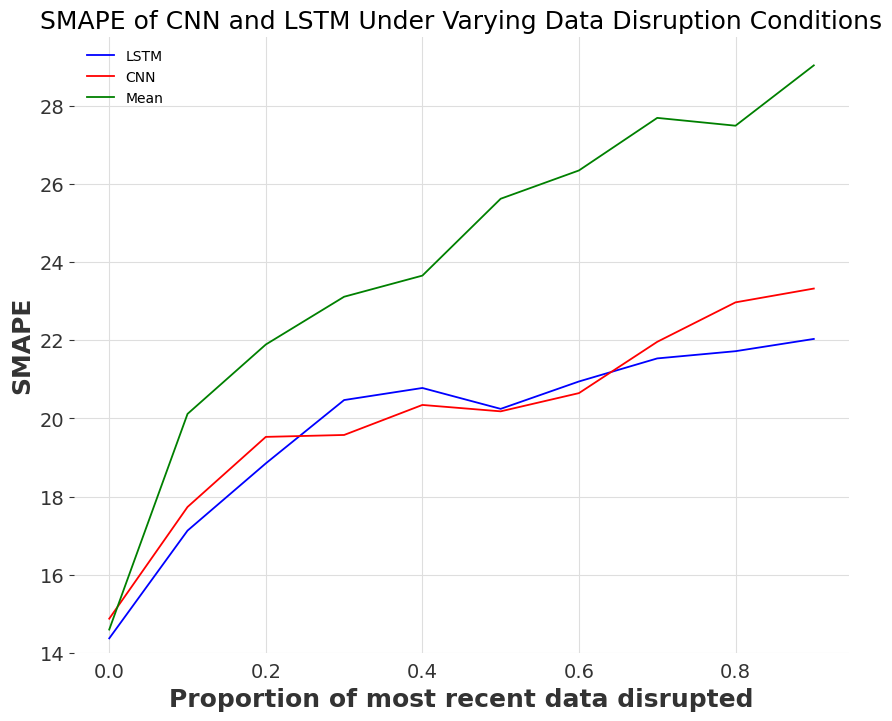

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
lstm_median['SMAPE'][::2].plot(label='LSTM', legend=True, fontsize=18, color='blue')
cnn_median['SMAPE'][::2].plot(label='CNN', legend=True, fontsize=18, color='red')
metrics_shuffle_lv_df['SMAPE'][::2].plot(label='Mean', legend=True, fontsize=18, color='green')
plt.title('SMAPE of CNN and LSTM Under Varying Data Disruption Conditions', fontsize=18)
plt.xlabel('Proportion of most recent data disrupted', fontsize=18)
plt.ylabel('SMAPE', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.ylim(ymin=14)  # Set the start of y-axis to 0
plt.show()

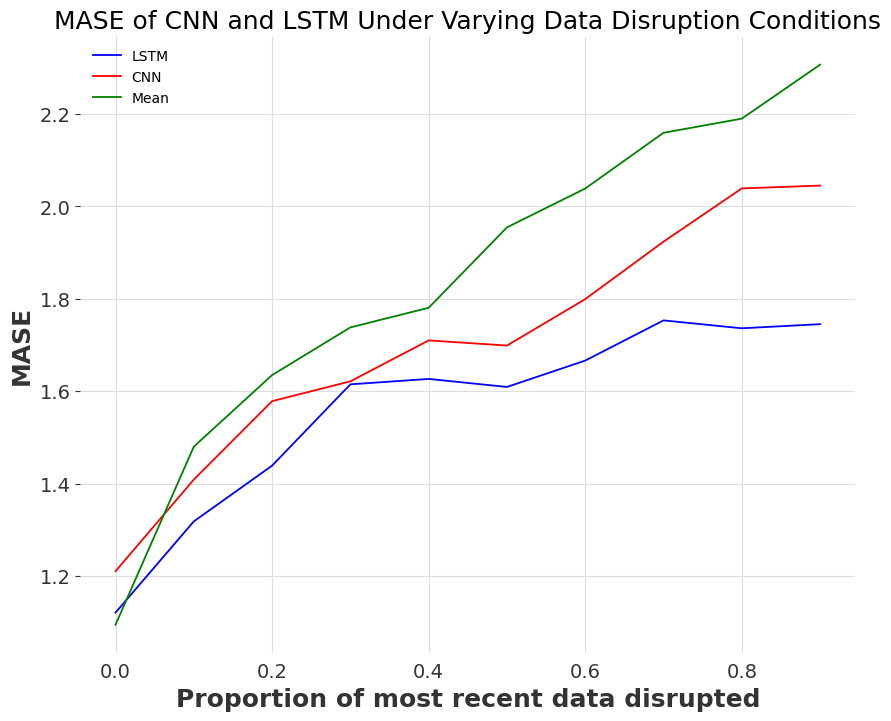

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
lstm_median['MASE'][::2].plot(label='LSTM', legend=True, fontsize=18, color='blue')
cnn_median['MASE'][::2].plot(label='CNN', legend=True, fontsize=18, color='red')
metrics_shuffle_lv_df['MASE'][::2].plot(label='Mean', legend=True, fontsize=18, color='green')
plt.title('MASE of CNN and LSTM Under Varying Data Disruption Conditions', fontsize=18)
plt.xlabel('Proportion of most recent data disrupted', fontsize=18)
plt.ylabel('MASE', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.show()

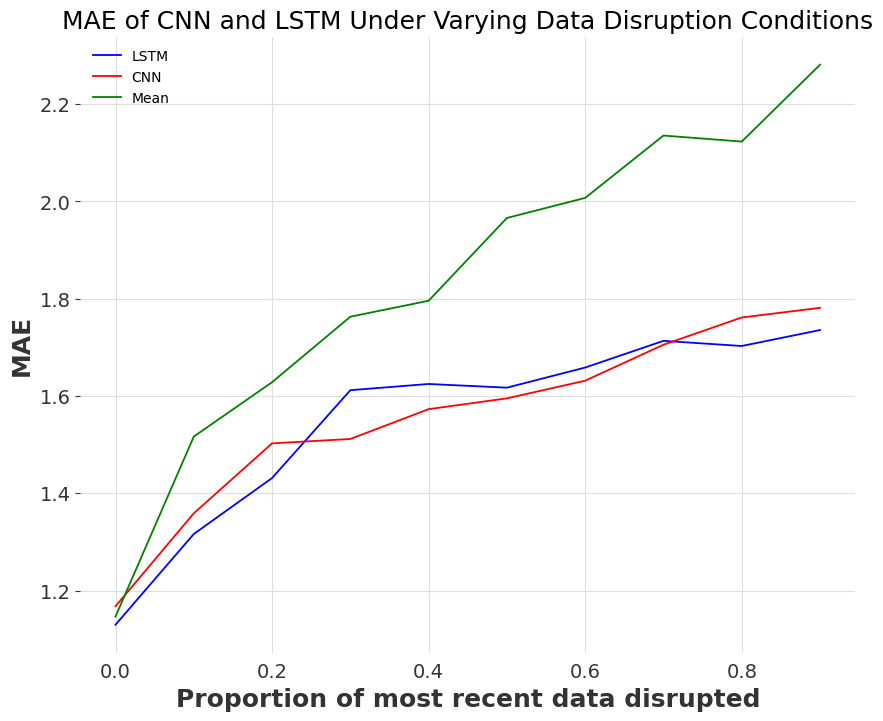

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
lstm_median['MAE'][::2].plot(label='LSTM', legend=True, fontsize=18, color='blue')
cnn_median['MAE'][::2].plot(label='CNN', legend=True, fontsize=18, color='red')
metrics_shuffle_lv_df['MAE'][::2].plot(label='Mean', legend=True, fontsize=18, color='green')
plt.title('MAE of CNN and LSTM Under Varying Data Disruption Conditions', fontsize=18)
plt.xlabel('Proportion of most recent data disrupted', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.show()

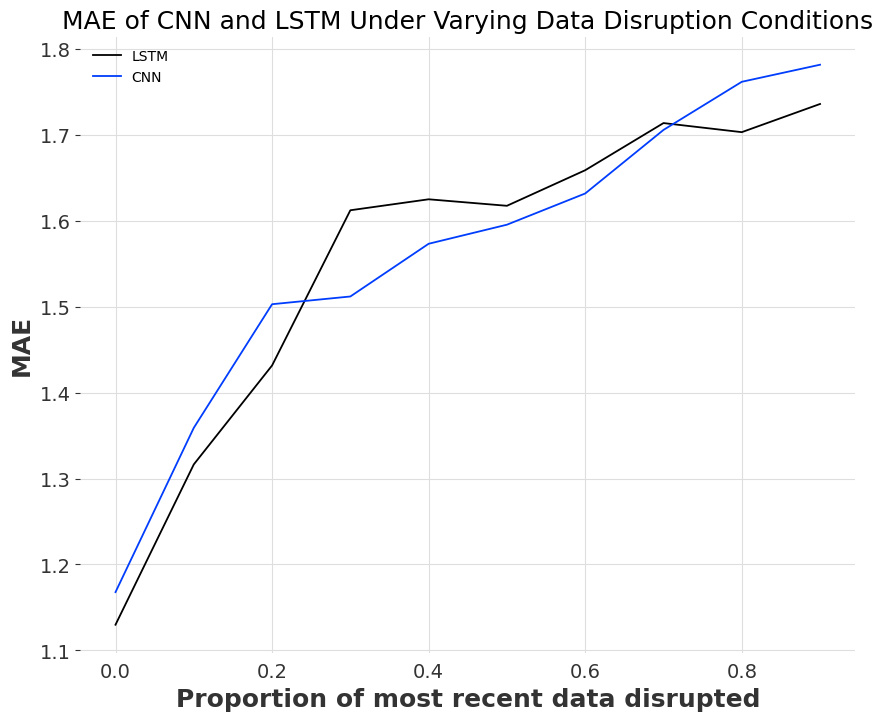

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
lstm_median['MAE'][::2].plot(label='LSTM', legend=True, fontsize=18)
cnn_median['MAE'][::2].plot(label='CNN', legend=True, fontsize=18)
#mean_metrics['SMAPE'][::4].plot(label='Mean', legend=True, fontsize=18)
plt.title('MAE of CNN and LSTM Under Varying Data Disruption Conditions', fontsize=18)
plt.xlabel('Proportion of most recent data disrupted', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.show()

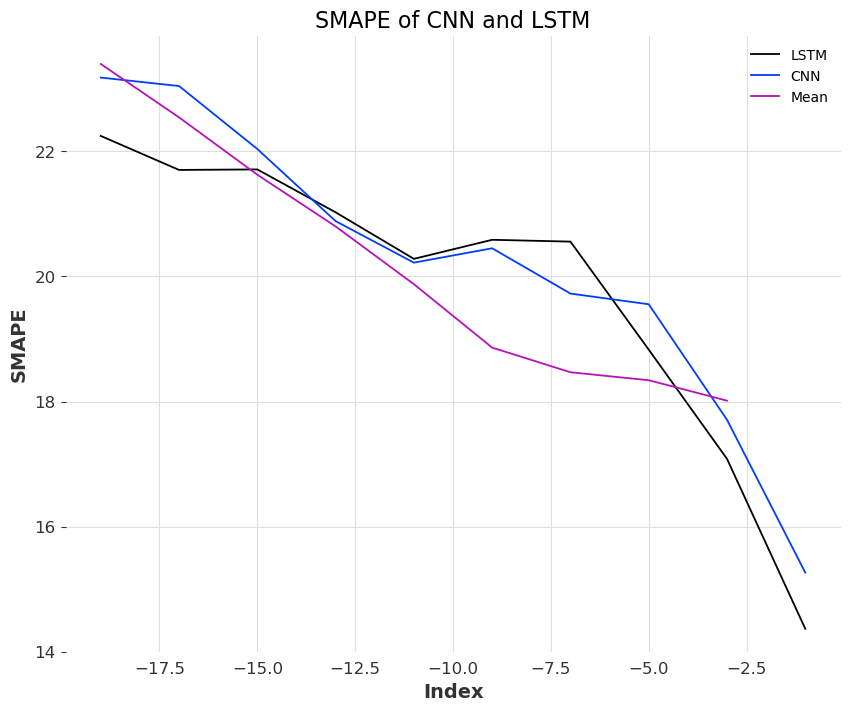

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
lstm_mean['SMAPE'][::2].plot(label='LSTM', legend=True, fontsize=18)
cnn_mean['SMAPE'][::2].plot(label='CNN', legend=True, fontsize=18)
mean_metrics['SMAPE'][::2].plot(label='Mean', legend=True, fontsize=18)
plt.title('SMAPE of CNN and LSTM', fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('SMAPE', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.ylim(ymin=14)  # Set the start of y-axis to 0
plt.show()

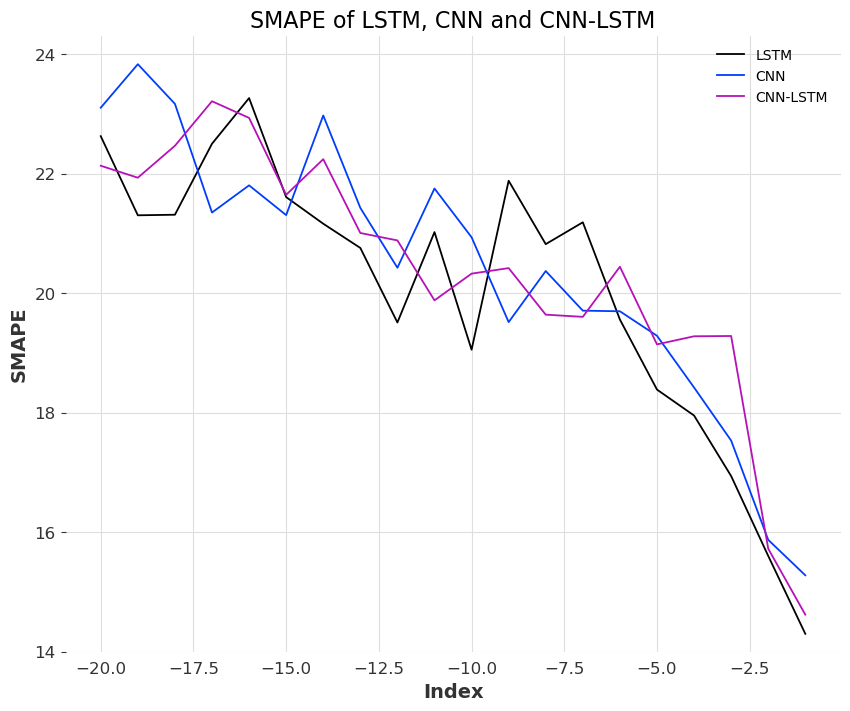

In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# lstm_detailed_df['SMAPE'].plot(label='LSTM', legend=True, fontsize=18)
# cnn_detailed_df['SMAPE'].plot(label='CNN', legend=True, fontsize=18)
# cnnlstm_detailed_df['SMAPE'].plot(label='CNN-LSTM', legend=True, fontsize=18)
lstm_detailed_df['SMAPE'].plot(label='LSTM', legend=True, fontsize=18)
cnn_detailed_df['SMAPE'].plot(label='CNN', legend=True, fontsize=18)
cnnlstm_detailed_df_['SMAPE'].plot(label='CNN-LSTM', legend=True, fontsize=18)
plt.title('SMAPE of LSTM, CNN and CNN-LSTM', fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('SMAPE', fontsize=18)
plt.tick_params(axis='both', labelsize=14)
plt.ylim(ymin=14)  # Set the start of y-axis to 0
plt.show()

In [86]:
# Shuffle last value

In [ ]:
df_total_shuf = df_total.copy()
df_total_shuf.iloc[-4+m:-4, :] = df_total_shuf.iloc[-4+m:-4, :].apply(np.random.shuffle, axis=0)


In [ ]:
df = TimeSeries.from_dataframe(df_total_shuf, freq='QS')

In [ ]:
def stats_sets(df=df):
    train_1, val_1 = df.split_before(pd.Timestamp('20230101'))
    train_2, val_2 = df.split_before(pd.Timestamp('20230401'))
    train_3, val_3 = df.split_before(pd.Timestamp('20230701'))
    return train_1, val_1, train_2, val_2, train_3, val_3   
train_1, val_1, train_2, val_2, train_3, val_3 = stats_sets()

In [ ]:
from darts.models import StatsForecastAutoARIMA

In [ ]:
from statsforecast import StatsForecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

horizon = 1 # number of predictions
autoarima_models= []
autoarima_residuals=[]
autoarima_models_string= []
models = [AutoARIMA(max_p=10, max_q=10, start_p=0, start_q=0, trace=False)]
pred_jan_2023 = []
for i, col in enumerate(train_1.columns):
    statsdf = train_1[col].pd_dataframe()
    statsdf['id'] = i
    statsdf.reset_index(inplace=True)
    statsdf["time"] = pd.to_datetime(statsdf["time"])
    statsdf.columns = ['ds', 'y', 'unique_id']
    sf = StatsForecast(df=statsdf,
                   models=models,
                   freq='QS', 
                   n_jobs=-1)
    sf.fit()
    result=sf.fitted_[0,0].model_
    autoarima_models.append(result['arma'])
    autoarima_models_string.append(arima_string(result))
    autoarima_residuals.append(pd.DataFrame(result.get("residuals"), columns=["residual Model"]))
    Y_hat_df = sf.forecast(horizon, fitted=True)
    pred = Y_hat_df['AutoARIMA'].values
    pred_jan_2023.append(pred)



In [ ]:
autoarima_dict = {}
include_mean_dict = {}
for i in range(len(autoarima_models_string)):
    result_tuple = autoarima_models_string[i].strip()[5:].split()
    result_tuple = tuple(int(x) for x in result_tuple[0].replace('(', '').replace(')', '').split(','))
    if "with zero mean" in autoarima_models_string[i]:
        include_mean = False
    else:
        include_mean = True
    autoarima_dict[df_total.columns[i]] = result_tuple
    include_mean_dict[df_total.columns[i]] = include_mean

In [ ]:
from statsforecast.models import ARIMA
pred_apr_2023 = []
for i, col in enumerate(train_2.columns):
    statsdf = train_2[col].pd_dataframe()
    statsdf['id'] = i
    statsdf.reset_index(inplace=True)
    statsdf["time"] = pd.to_datetime(statsdf["time"])
    statsdf.columns = ['ds', 'y', 'unique_id']
    order = autoarima_dict[col]
    include_mean = include_mean_dict[col]
    arima = ARIMA(order=order, include_mean=include_mean)
    arima = arima.fit(y=statsdf["y"].values)
    y_hat_dict = arima.predict(h=1,)
    pred = y_hat_dict['mean'][0]
    pred_apr_2023.append(pred)


In [ ]:
from statsforecast.models import ARIMA
pred_jul_2023 = []
for i, col in enumerate(train_3.columns):
    statsdf = train_3[col].pd_dataframe()
    statsdf['id'] = i
    statsdf.reset_index(inplace=True)
    statsdf["time"] = pd.to_datetime(statsdf["time"])
    statsdf.columns = ['ds', 'y', 'unique_id']
    order = autoarima_dict[col]
    include_mean = include_mean_dict[col]
    arima = ARIMA(order=order, include_mean=include_mean)
    arima = arima.fit(y=statsdf["y"].values)
    y_hat_dict = arima.predict(h=1,)
    pred = y_hat_dict['mean'][0]
    pred_jul_2023.append(pred)


In [ ]:
preds = pd.concat([pd.DataFrame(pred_jan_2023).T, pd.DataFrame(pred_apr_2023).T, pd.DataFrame(pred_jul_2023).T], axis=0)


In [ ]:
preds.index = [pd.Timestamp('20230101'), pd.Timestamp('20230401'), pd.Timestamp('20230701')]
preds.columns = df_total.columns

In [ ]:
arima_preds = TimeSeries.from_dataframe(preds)

In [ ]:
print(
    "Mean absolute percentage error: {:.2f}%.".format(
        mape(val_1, arima_preds)
    ),
      "Mean absolute scaled error: {:.2f}%.".format(
        mase(val_1, arima_preds, train_1)),
          "SMAPE: {:.2f}%.".format(
        smape(val_1, arima_preds)),
        
    "MAE: {:.8f}.".format(
        mae(val_1, arima_preds)),
        
    "RMSE: {:.8f}.".format(
        rmse(val_1, arima_preds))
    )


Mean absolute percentage error: 23.38%. Mean absolute scaled error: 1.19%. SMAPE: 16.04%. MAE: 1.26103091. RMSE: 1.50103790.
